In [1]:
%matplotlib inline
from pylab import *
import numpy as np
from craco.search_pipeline import location2pix, get_grid_lut_from_plan, grid_candidates,wait_for_starts,waitall,print_candidates
from craco.search_pipeline import NBINARY_POINT_FDMTIN 
import craco
import craco.search_pipeline
from craco.pyxrtutil import *
import craft.craco_plan

from craft import uvfits

from craft.craco_plan import PipelinePlan
from craft.craco import printstats
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("test")
import time


INFO:root:test


In [2]:
fits='/data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm00/frb_d0_t0_a1_sninf_lm00.fits'
xclbin='/data/craco/ban115/builds/binary_container_1_10688715.xclbin'
#xclbin='/data/craco/ban115/builds/binary_container_01482863.xclbin'
alloc_device_only=True

In [3]:
values = craco.search_pipeline.get_parser().parse_args([])
print(values)

Namespace(boxcar_weight='sum', cand_file='candidates.txt', cell=None, device=0, dump_boxcar_hist_buf=None, dump_candidates=None, dump_fdmt_hist_buf=None, dump_mainbufs=None, dump_uvdata=None, fdmt_scale=1.0, fft_scale=10.0, fft_shift1=0, fft_shift2=7, injection_file=None, input_scale=1.0, max_ndm=1024, nblocks=None, nbox=8, ncin=32, ndm=2, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1,2.1', run_fdmt=True, run_image=True, show=False, show_candidate_grid=None, threshold=10.0, uv='frb_d0_lm0_nt16_nant24.fits', verbose=False, wait=False, xclbin='binary_container_1.xclbin.golden')


In [4]:
device = pyxrt.device(1)
xbin = pyxrt.xclbin(xclbin)
uuid = device.load_xclbin(xbin)


In [5]:
f = uvfits.open(fits)
plan = PipelinePlan(f, "--ndm 512 --ndout 186")

INFO:root:Opening file /data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm00/frb_d0_t0_a1_sninf_lm00.fits
INFO:craft.craco_plan:making Plan values=Namespace(boxcar_weight='sum', cell=None, fdmt_scale=1.0, fft_scale=10.0, max_nbl=630.0, max_ndm=1024, nbox=8, ncin=32, ndm=512, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1,2.1', pickle_fname='pipeline.pickle', save=False, show=False, show_fdmt=False, show_image=False, threshold=3, uv='uv_data', verbose=False)
INFO:craft.craco_plan:Nbl=190 Fch1=735499993.944000 foff=1000000.047500 nchan=256 lambdamin=0.302877 uvmax=(2914.412072271962, 3548.709136210335) max baseline=(0.882709355209954, 1.0748235581559127) resolution=[70.77407077 58.12389754]arcsec uvcell=[33.70193846 27.67804645] arcsec uvcell= (23.90728653035594, 29.110504632975406) lambda FoV=[2.39658229 1.96821664] deg oversampled=(2.1, 2.1)
INFO:craft.craco_plan:Got Ncells=3838 uvcells


parsing values --ndm 512 --ndout 186


INFO:craft.craco_plan:FDMT plan has ntotal=5272 of 659 runs with packing efficiency 0.727997. Grid read requires efficiency of > 0.643555 of NUV=8192. History size square=753094656 minimal=163322152 =2 256MB HBM banks
INFO:craft.craco_plan:FDMT zero cell is (658, 2)=5266
INFO:craft.craco_plan:Saving uvgrid.split shape=(5245, 14) type=float64 to uv_data.uvgrid.split.txt header=ant1, ant2, u(pix), v(pix), chan1, chan2, irun, icell, total_overlap, max_idm, max_offset, offset_cff, idm_cff, fch1
INFO:craft.craco_plan:Got 3398 unique UV coords. Upper=True
INFO:craft.craco_plan:Need to write 213 groups of 16 register to pad function
INFO:craft.craco_plan:Got 3377 unique UV coords. Upper=False
INFO:craft.craco_plan:Need to write 212 groups of 16 register to pad function
INFO:craft.craco_plan:Got 5354 upper grid instructions
INFO:craft.craco_plan:Saving gridlut.upper shape=(5354, 5) type=int32 to uv_data.gridlut.upper.txt header=target_slot, uvidx, shift_flag, upix, vpix
INFO:craft.craco_plan:G

Upper registers [(37, 6), (37, 7), (38, 7), (38, 8), (39, 8), (39, 9), (40, 9), (40, 10), (40, 11), (41, 11), (102, 11), (41, 12), (42, 12), (102, 12), (42, 13), (43, 13), (102, 13), (43, 14), (102, 14), (103, 14), (18, 15), (43, 15), (44, 15), (103, 15), (18, 16), (19, 16), (44, 16), (45, 16), (103, 16), (19, 17), (20, 17), (45, 17)]
Lower registers [(26, 47), (26, 48), (27, 48), (27, 49), (28, 49), (28, 50), (29, 50), (30, 51), (31, 51), (31, 52), (32, 52), (32, 53), (33, 53), (33, 54), (34, 54), (35, 54), (35, 55), (36, 55), (53, 55), (54, 55), (6, 56), (36, 56), (37, 56), (54, 56), (55, 56), (7, 57), (8, 57), (37, 57), (38, 57), (55, 57), (56, 57), (8, 58)]


INFO:craft.craco_plan:Saving doshift.lower shape=(4096,) type=int32 to uv_data.doshift.lower.txt header=doshift
INFO:craft.craco_plan:Saving ddreader shape=(2048,) type=uint32 to uv_data.ddreader.txt header=value


In [6]:
print(plan.ndout)

186


In [7]:
p = craco.search_pipeline.Pipeline(device, xbin, plan, alloc_device_only)

INFO:craco.search_pipeline:2636 2677 2664
INFO:craco.search_pipeline:(180214,)


Kernel krnl_ddgrid_reader_4cu:krnl_ddgrid_reader_4cu_1 has groups
GID=0=32
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=15
Kernel krnl_grid_4cu:krnl_grid_4cu_1 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=6
Kernel krnl_grid_4cu:krnl_grid_4cu_2 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=7
Kernel krnl_grid_4cu:krnl_grid_4cu_3 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=20
Kernel krnl_grid_4cu:krnl_grid_4cu_4 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=21
Kernel fft2d:fft2d_1 has groups
Kernel fft2d:fft2d_2 has groups
Kernel fft2d:fft2d_3 has groups
Kernel fft2d:fft2d_4 has groups
Kernel krnl_boxc_4cu:krnl_boxc_4cu_1 has groups
GID=0=-1


INFO:craco.search_pipeline:lut.shape (180214,)
INFO:craco.search_pipeline:nuv 5272
INFO:craco.search_pipeline:Allocating grid LUTs
INFO:craco.search_pipeline:Allocating FDMT Input
INFO:craco.search_pipeline:5272
INFO:craco.search_pipeline:256
INFO:craco.search_pipeline:32
INFO:craco.search_pipeline:8
INFO:craco.search_pipeline:659
INFO:craco.search_pipeline:186
INFO:craco.search_pipeline:FDMT input buffer size 164.75 MB
INFO:craco.search_pipeline:Allocating FDMT history


GID=1=-1
GID=2=-1
GID=3=54
GID=4=54
GID=5=4
Kernel fdmt_tunable_c32:fdmt_tunable_c32_1 has groups
GID=0=52
GID=1=32
GID=2=53
GID=3=53
GID=4=14
Allocated 360428 bytes flags=flags.normal groupid=6 address=0x60000000
Allocated 360428 bytes flags=flags.normal groupid=7 address=0x70000000
Allocated 360428 bytes flags=flags.normal groupid=20 address=0x140000000
Allocated 360428 bytes flags=flags.normal groupid=21 address=0x150000000
Allocated 172752896 bytes flags=flags.normal groupid=52 address=0x90000000
Allocated 268435456 bytes flags=flags.normal groupid=53 address=0xa0000000


INFO:craco.search_pipeline:Allocating mainbuf
INFO:craco.search_pipeline:FDMT output buffer size 10.286819458007812 GB
INFO:craco.search_pipeline:Mainbuf shape is (659, 186, 11, 256, 8, 2) breaking into 8 buffers of [83, 186, 11, 256, 8, 2]


Allocated 653728 bytes flags=flags.normal groupid=14 address=0xe0000000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x4000000000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x4052eb4000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x40a5d68000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x40f8c1c000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x414bad0000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x419e984000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x41f1838000
Allocated 1391149056 bytes flags=flags.normal groupid=32 address=0x42446ec000


INFO:craco.search_pipeline:Allocating ddreader_lut
INFO:craco.search_pipeline:Allocating boxcar_history


Allocated 8192 bytes flags=flags.normal groupid=15 address=0xf0000000
Allocated 1073741824 bytes flags=flags.normal groupid=54 address=0x0


INFO:craco.search_pipeline:Boxcar history (1024, 8, 256, 256) 1073741824 2
INFO:craco.search_pipeline:Allocating candidates


Allocated 1048576 bytes flags=flags.normal groupid=4 address=0x40000000


In [58]:
p.clear_buffers(values)
# dmamp = 32 gives SNR=14.2
dmamp = 32
t0 = 252 # If I make t0=between 255-NBOX (-1?) and 255 I should see it in the boxcar history
dm = 0

# put in a value for a single time and DM
for b in p.all_mainbufs:
    print(b.shape)
    #b.nparr[:] = dmamp #np.random.randn(*b.nparr.shape)
    #b.nparr[:] = dmamp
    b.nparr[:,dm,0,t0,:,0] = dmamp
    b.copy_to_device() 

INFO:craco.search_pipeline:Clearing mainbuf data NBLK=11


[83, 186, 11, 256, 8, 2]
[83, 186, 11, 256, 8, 2]
[83, 186, 11, 256, 8, 2]
[83, 186, 11, 256, 8, 2]
[83, 186, 11, 256, 8, 2]
[83, 186, 11, 256, 8, 2]
[83, 186, 11, 256, 8, 2]
[83, 186, 11, 256, 8, 2]


In [59]:
mainbuf = p.copy_mainbuf()

(664, 186, 11, 256, 8, 2)
169984


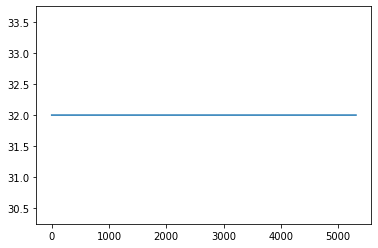

In [60]:
print(mainbuf.shape)
plot(mainbuf[:,0,0,t0,:,0].flat)
assert np.all(mainbuf[:,0,0,t0,:,0] == dmamp)
assert np.all(mainbuf[:,1:,1:,:t0,:,1] == 0)
assert np.all(mainbuf[:,1:,1:,:t0+1,:,1] == 0)
print(mainbuf.sum())

In [61]:
values.run_fdmt = False
values.run_image = True
values.threshold = 10
print(values)
p.run(0, values).wait()

INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running


Namespace(boxcar_weight='sum', cand_file='candidates.txt', cell=None, device=0, dump_boxcar_hist_buf=None, dump_candidates=None, dump_fdmt_hist_buf=None, dump_mainbufs=None, dump_uvdata=None, fdmt_scale=1.0, fft_scale=10.0, fft_shift1=0, fft_shift2=7, injection_file=None, input_scale=0.0625, max_ndm=1024, nblocks=None, nbox=8, ncin=32, ndm=2, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1,2.1', run_fdmt=False, run_image=True, show=False, show_candidate_grid=None, threshold=10, uv='frb_d0_lm0_nt16_nant24.fits', verbose=False, wait=False, xclbin='binary_container_1.xclbin.golden')


INFO:craco.search_pipeline:Waiting for 10 starts


In [62]:
cands = p.get_candidates()
print(f'Got {len(cands)} candidates')
if len(cands) == 0: # are you sure?
    p.candidates.copy_from_device()
    print(p.candidates.nparr)
    
print_candidates(cands, 256, 0)
print("The sume all the numbufs was", mainbuf.sum())

INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)


Got 17 candidates
# SNR	upix	vpix	boxc_width	time	dm	iblk	rawsn

83.4	128	128	0		252	0	0	5340
35.0	127	129	0		252	0	0	2238
12.0	122	138	0		252	0	0	768
11.0	121	139	0		252	0	0	702
11.0	135	117	0		252	0	0	702
12.0	134	118	0		252	0	0	768
35.0	129	127	0		252	0	0	2238
58.7	128	128	1		253	1	0	3754
24.5	127	129	1		253	1	0	1569
24.7	129	127	1		253	1	0	1578
46.9	128	128	2		254	2	0	3003
19.7	127	129	2		254	2	0	1260
19.7	129	127	2		254	2	0	1259
41.4	128	128	2		255	3	0	2648
17.2	127	129	1		254	3	0	1101
17.3	129	127	1		254	3	0	1108
20.5	128	128	1		255	4	0	1309
The sume all the numbufs was 169984


Boxcar max boxcar=0 max=0
Boxcar max boxcar=1 max=0
Boxcar max boxcar=2 max=130
Boxcar max boxcar=3 max=21360
Boxcar max boxcar=4 max=0
Boxcar max boxcar=5 max=0
Boxcar max boxcar=6 max=0
Boxcar max boxcar=7 max=0


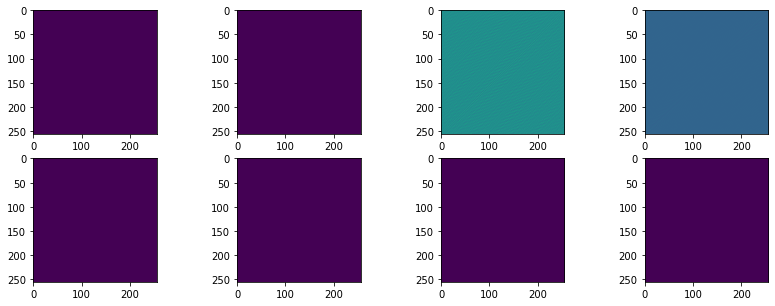

In [77]:
p.boxcar_history.copy_from_device()
fig, ax = subplots(2,4)
fig.set_size_inches(14,5)
ax = ax.flatten()
for b, myax in zip(range(p.boxcar_history.shape[1]), ax):
    d = p.boxcar_history.nparr[dm, b, :, :]
    print(f'Boxcar max boxcar={b} max={d.max()}')
    myax.imshow(d)

In [13]:
print(cands)
cands = cands[cands['dm'] == 0] # DM 0 adn 1 are repeated, I think.

[(5340,     0, 0, 0, 0) (2238,   511, 0, 0, 0) ( 768,  2810, 0, 0, 0)
 ( 702,  3065, 0, 0, 0) ( 702, 62727, 0, 0, 0) ( 768, 62982, 0, 0, 0)
 (2238, 65281, 0, 0, 0) (3754,     0, 1, 1, 1) (1569,   511, 1, 1, 1)
 (1578, 65281, 1, 1, 1) ( 981,     0, 7, 8, 1) (2655,     0, 1, 1, 2)
 (1184,   511, 1, 1, 2) (1183, 65281, 1, 1, 2) (1398,     0, 7, 8, 2)
 (2060,     0, 4, 5, 3) ( 852,   511, 0, 1, 3) ( 852, 65281, 0, 1, 3)
 (1618,     0, 7, 8, 3) ( 655,   511, 7, 8, 3) ( 658, 65281, 7, 8, 3)
 (1309,     0, 1, 5, 4) ( 814,     0, 4, 8, 4)]


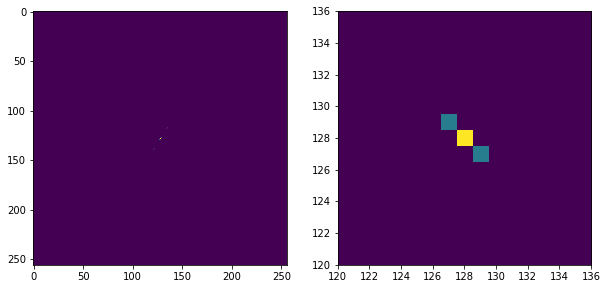

In [14]:
grid = grid_candidates(cands, 'snr')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

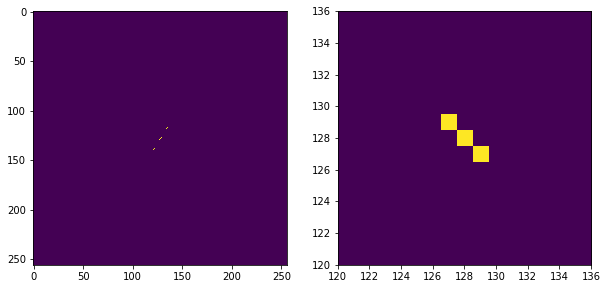

In [15]:
grid = grid_candidates(cands, 'count')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

# Check DM0 for trange makes sense

In [16]:
location2pix(0)

(array(128), array(128))

In [17]:
all_cands = []
dm = 0
for t0 in range(16):
    p.clear_buffers(values)
    # dmamp = 32 gives SNR=14.2
    dmamp = 32
    print('t0', t0)

    # put in a value for a single time and DM
    for b in p.all_mainbufs:
        b.nparr[:] = 0
        b.nparr[:,dm,0,t0,:,0] = dmamp
        b.copy_to_device()

    values.run_fdmt = False
    values.run_image = True
    values.threshold = 5
    p.run(0, values).wait()
    cands = p.get_candidates().copy()
    all_cands.append(cands)
    c0 = cands[0]
    print(c0)
    #assert c0['upix'] == 128
    #assert c0['vpix'] == 128
    #assert c0['boxc_width'] == 0
    #assert c0['time'] == t0
    #assert c0['dm'] == 0
    print_candidates(cands, 256, 0)
    centrepix = cands[cands['loc_2dfft'] == 0] # 128, 128
    print_candidates(centrepix, 256,0)
    

    

INFO:craco.search_pipeline:Clearing mainbuf data NBLK=11


t0 0


INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=320 shift1=0 shift2=7 fft_cfg=400001c0

INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Clearing mainbuf data NBLK=11


(5340, 0, 0, 0, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk	rawsn

83.4	128	128	0		0	0	0	5340
7.2	129	129	0		0	0	0	460
35.0	127	129	0		0	0	0	2238
7.8	138	130	0		0	0	0	496
5.3	122	130	0		0	0	0	337
7.6	128	131	0		0	0	0	489
5.1	115	131	0		0	0	0	327
5.1	134	132	0		0	0	0	325
8.1	124	132	0		0	0	0	517
7.9	133	133	0		0	0	0	505
8.2	125	133	0		0	0	0	528
6.6	134	134	0		0	0	0	421
5.1	126	134	0		0	0	0	325
7.0	135	135	0		0	0	0	450
5.4	127	135	0		0	0	0	343
6.3	136	136	0		0	0	0	401
6.8	110	136	0		0	0	0	438
8.2	114	136	0		0	0	0	524
6.0	135	137	0		0	0	0	383
5.5	179	137	0		0	0	0	352
5.3	109	137	0		0	0	0	342
5.6	113	137	0		0	0	0	358
12.0	122	138	0		0	0	0	768
5.5	91	139	0		0	0	0	350
11.0	121	139	0		0	0	0	702
7.9	120	140	0		0	0	0	507
5.2	111	141	0		0	0	0	335
7.4	123	141	0		0	0	0	476
5.1	71	145	0		0	0	0	329
6.2	116	148	0		0	0	0	400
8.3	115	149	0		0	0	0	530
5.2	114	150	0		0	0	0	336
6.0	97	155	0		0	0	0	387
6.2	115	155	0		0	0	0	396
5.9	96	156	0		0	0	0	378
5.6	95	157	0		0	0	0	360
5.8	111	161	0		0	0	0	370
5.8	145	

INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=320 shift1=0 shift2=7 fft_cfg=400001c0

INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Clearing mainbuf data NBLK=11


(5340, 0, 0, 1, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk	rawsn

83.4	128	128	0		1	0	0	5340
7.2	129	129	0		1	0	0	460
35.0	127	129	0		1	0	0	2238
7.8	138	130	0		1	0	0	496
5.3	122	130	0		1	0	0	337
7.6	128	131	0		1	0	0	489
5.1	115	131	0		1	0	0	327
5.1	134	132	0		1	0	0	325
8.1	124	132	0		1	0	0	517
7.9	133	133	0		1	0	0	505
8.2	125	133	0		1	0	0	528
6.6	134	134	0		1	0	0	421
5.1	126	134	0		1	0	0	325
7.0	135	135	0		1	0	0	450
5.4	127	135	0		1	0	0	343
6.3	136	136	0		1	0	0	401
6.8	110	136	0		1	0	0	438
8.2	114	136	0		1	0	0	524
6.0	135	137	0		1	0	0	383
5.5	179	137	0		1	0	0	352
5.3	109	137	0		1	0	0	342
5.6	113	137	0		1	0	0	358
12.0	122	138	0		1	0	0	768
5.5	91	139	0		1	0	0	350
11.0	121	139	0		1	0	0	702
7.9	120	140	0		1	0	0	507
5.2	111	141	0		1	0	0	335
7.4	123	141	0		1	0	0	476
5.1	71	145	0		1	0	0	329
6.2	116	148	0		1	0	0	400
8.3	115	149	0		1	0	0	530
5.2	114	150	0		1	0	0	336
6.0	97	155	0		1	0	0	387
6.2	115	155	0		1	0	0	396
5.9	96	156	0		1	0	0	378
5.6	95	157	0		1	0	0	360
5.8	111	161	0		1	0	0	370
5.8	145	

INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=320 shift1=0 shift2=7 fft_cfg=400001c0

INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Clearing mainbuf data NBLK=11


(5340, 0, 0, 2, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk	rawsn

83.4	128	128	0		2	0	0	5340
7.2	129	129	0		2	0	0	460
35.0	127	129	0		2	0	0	2238
7.8	138	130	0		2	0	0	496
5.3	122	130	0		2	0	0	337
7.6	128	131	0		2	0	0	489
5.1	115	131	0		2	0	0	327
5.1	134	132	0		2	0	0	325
8.1	124	132	0		2	0	0	517
7.9	133	133	0		2	0	0	505
8.2	125	133	0		2	0	0	528
6.6	134	134	0		2	0	0	421
5.1	126	134	0		2	0	0	325
7.0	135	135	0		2	0	0	450
5.4	127	135	0		2	0	0	343
6.3	136	136	0		2	0	0	401
6.8	110	136	0		2	0	0	438
8.2	114	136	0		2	0	0	524
6.0	135	137	0		2	0	0	383
5.5	179	137	0		2	0	0	352
5.3	109	137	0		2	0	0	342
5.6	113	137	0		2	0	0	358
12.0	122	138	0		2	0	0	768
5.5	91	139	0		2	0	0	350
11.0	121	139	0		2	0	0	702
7.9	120	140	0		2	0	0	507
5.2	111	141	0		2	0	0	335
7.4	123	141	0		2	0	0	476
5.1	71	145	0		2	0	0	329
6.2	116	148	0		2	0	0	400
8.3	115	149	0		2	0	0	530
5.2	114	150	0		2	0	0	336
6.0	97	155	0		2	0	0	387
6.2	115	155	0		2	0	0	396
5.9	96	156	0		2	0	0	378
5.6	95	157	0		2	0	0	360
5.8	111	161	0		2	0	0	370
5.8	145	

INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=320 shift1=0 shift2=7 fft_cfg=400001c0

INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Clearing mainbuf data NBLK=11


(5340, 0, 0, 3, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk	rawsn

83.4	128	128	0		3	0	0	5340
7.2	129	129	0		3	0	0	460
35.0	127	129	0		3	0	0	2238
7.8	138	130	0		3	0	0	496
5.3	122	130	0		3	0	0	337
7.6	128	131	0		3	0	0	489
5.1	115	131	0		3	0	0	327
5.1	134	132	0		3	0	0	325
8.1	124	132	0		3	0	0	517
7.9	133	133	0		3	0	0	505
8.2	125	133	0		3	0	0	528
6.6	134	134	0		3	0	0	421
5.1	126	134	0		3	0	0	325
7.0	135	135	0		3	0	0	450
5.4	127	135	0		3	0	0	343
6.3	136	136	0		3	0	0	401
6.8	110	136	0		3	0	0	438
8.2	114	136	0		3	0	0	524
6.0	135	137	0		3	0	0	383
5.5	179	137	0		3	0	0	352
5.3	109	137	0		3	0	0	342
5.6	113	137	0		3	0	0	358
12.0	122	138	0		3	0	0	768
5.5	91	139	0		3	0	0	350
11.0	121	139	0		3	0	0	702
7.9	120	140	0		3	0	0	507
5.2	111	141	0		3	0	0	335
7.4	123	141	0		3	0	0	476
5.1	71	145	0		3	0	0	329
6.2	116	148	0		3	0	0	400
8.3	115	149	0		3	0	0	530
5.2	114	150	0		3	0	0	336
6.0	97	155	0		3	0	0	387
6.2	115	155	0		3	0	0	396
5.9	96	156	0		3	0	0	378
5.6	95	157	0		3	0	0	360
5.8	111	161	0		3	0	0	370
5.8	145	

INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=320 shift1=0 shift2=7 fft_cfg=400001c0

INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Clearing mainbuf data NBLK=11


(5340, 0, 0, 4, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk	rawsn

83.4	128	128	0		4	0	0	5340
7.2	129	129	0		4	0	0	460
35.0	127	129	0		4	0	0	2238
7.8	138	130	0		4	0	0	496
5.3	122	130	0		4	0	0	337
7.6	128	131	0		4	0	0	489
5.1	115	131	0		4	0	0	327
5.1	134	132	0		4	0	0	325
8.1	124	132	0		4	0	0	517
7.9	133	133	0		4	0	0	505
8.2	125	133	0		4	0	0	528
6.6	134	134	0		4	0	0	421
5.1	126	134	0		4	0	0	325
7.0	135	135	0		4	0	0	450
5.4	127	135	0		4	0	0	343
6.3	136	136	0		4	0	0	401
6.8	110	136	0		4	0	0	438
8.2	114	136	0		4	0	0	524
6.0	135	137	0		4	0	0	383
5.5	179	137	0		4	0	0	352
5.3	109	137	0		4	0	0	342
5.6	113	137	0		4	0	0	358
12.0	122	138	0		4	0	0	768
5.5	91	139	0		4	0	0	350
11.0	121	139	0		4	0	0	702
7.9	120	140	0		4	0	0	507
5.2	111	141	0		4	0	0	335
7.4	123	141	0		4	0	0	476
5.1	71	145	0		4	0	0	329
6.2	116	148	0		4	0	0	400
8.3	115	149	0		4	0	0	530
5.2	114	150	0		4	0	0	336
6.0	97	155	0		4	0	0	387
6.2	115	155	0		4	0	0	396
5.9	96	156	0		4	0	0	378
5.6	95	157	0		4	0	0	360
5.8	111	161	0		4	0	0	370
5.8	145	

INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=320 shift1=0 shift2=7 fft_cfg=400001c0

INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Clearing mainbuf data NBLK=11


(5340, 0, 0, 5, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk	rawsn

83.4	128	128	0		5	0	0	5340
7.2	129	129	0		5	0	0	460
35.0	127	129	0		5	0	0	2238
7.8	138	130	0		5	0	0	496
5.3	122	130	0		5	0	0	337
7.6	128	131	0		5	0	0	489
5.1	115	131	0		5	0	0	327
5.1	134	132	0		5	0	0	325
8.1	124	132	0		5	0	0	517
7.9	133	133	0		5	0	0	505
8.2	125	133	0		5	0	0	528
6.6	134	134	0		5	0	0	421
5.1	126	134	0		5	0	0	325
7.0	135	135	0		5	0	0	450
5.4	127	135	0		5	0	0	343
6.3	136	136	0		5	0	0	401
6.8	110	136	0		5	0	0	438
8.2	114	136	0		5	0	0	524
6.0	135	137	0		5	0	0	383
5.5	179	137	0		5	0	0	352
5.3	109	137	0		5	0	0	342
5.6	113	137	0		5	0	0	358
12.0	122	138	0		5	0	0	768
5.5	91	139	0		5	0	0	350
11.0	121	139	0		5	0	0	702
7.9	120	140	0		5	0	0	507
5.2	111	141	0		5	0	0	335
7.4	123	141	0		5	0	0	476
5.1	71	145	0		5	0	0	329
6.2	116	148	0		5	0	0	400
8.3	115	149	0		5	0	0	530
5.2	114	150	0		5	0	0	336
6.0	97	155	0		5	0	0	387
6.2	115	155	0		5	0	0	396
5.9	96	156	0		5	0	0	378
5.6	95	157	0		5	0	0	360
5.8	111	161	0		5	0	0	370
5.8	145	

INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=320 shift1=0 shift2=7 fft_cfg=400001c0

INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Clearing mainbuf data NBLK=11


(5340, 0, 0, 6, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk	rawsn

83.4	128	128	0		6	0	0	5340
7.2	129	129	0		6	0	0	460
35.0	127	129	0		6	0	0	2238
7.8	138	130	0		6	0	0	496
5.3	122	130	0		6	0	0	337
7.6	128	131	0		6	0	0	489
5.1	115	131	0		6	0	0	327
5.1	134	132	0		6	0	0	325
8.1	124	132	0		6	0	0	517
7.9	133	133	0		6	0	0	505
8.2	125	133	0		6	0	0	528
6.6	134	134	0		6	0	0	421
5.1	126	134	0		6	0	0	325
7.0	135	135	0		6	0	0	450
5.4	127	135	0		6	0	0	343
6.3	136	136	0		6	0	0	401
6.8	110	136	0		6	0	0	438
8.2	114	136	0		6	0	0	524
6.0	135	137	0		6	0	0	383
5.5	179	137	0		6	0	0	352
5.3	109	137	0		6	0	0	342
5.6	113	137	0		6	0	0	358
12.0	122	138	0		6	0	0	768
5.5	91	139	0		6	0	0	350
11.0	121	139	0		6	0	0	702
7.9	120	140	0		6	0	0	507
5.2	111	141	0		6	0	0	335
7.4	123	141	0		6	0	0	476
5.1	71	145	0		6	0	0	329
6.2	116	148	0		6	0	0	400
8.3	115	149	0		6	0	0	530
5.2	114	150	0		6	0	0	336
6.0	97	155	0		6	0	0	387
6.2	115	155	0		6	0	0	396
5.9	96	156	0		6	0	0	378
5.6	95	157	0		6	0	0	360
5.8	111	161	0		6	0	0	370
5.8	145	

INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=320 shift1=0 shift2=7 fft_cfg=400001c0

INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Clearing mainbuf data NBLK=11


(5340, 0, 0, 7, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk	rawsn

83.4	128	128	0		7	0	0	5340
7.2	129	129	0		7	0	0	460
35.0	127	129	0		7	0	0	2238
7.8	138	130	0		7	0	0	496
5.3	122	130	0		7	0	0	337
7.6	128	131	0		7	0	0	489
5.1	115	131	0		7	0	0	327
5.1	134	132	0		7	0	0	325
8.1	124	132	0		7	0	0	517
7.9	133	133	0		7	0	0	505
8.2	125	133	0		7	0	0	528
6.6	134	134	0		7	0	0	421
5.1	126	134	0		7	0	0	325
7.0	135	135	0		7	0	0	450
5.4	127	135	0		7	0	0	343
6.3	136	136	0		7	0	0	401
6.8	110	136	0		7	0	0	438
8.2	114	136	0		7	0	0	524
6.0	135	137	0		7	0	0	383
5.5	179	137	0		7	0	0	352
5.3	109	137	0		7	0	0	342
5.6	113	137	0		7	0	0	358
12.0	122	138	0		7	0	0	768
5.5	91	139	0		7	0	0	350
11.0	121	139	0		7	0	0	702
7.9	120	140	0		7	0	0	507
5.2	111	141	0		7	0	0	335
7.4	123	141	0		7	0	0	476
5.1	71	145	0		7	0	0	329
6.2	116	148	0		7	0	0	400
8.3	115	149	0		7	0	0	530
5.2	114	150	0		7	0	0	336
6.0	97	155	0		7	0	0	387
6.2	115	155	0		7	0	0	396
5.9	96	156	0		7	0	0	378
5.6	95	157	0		7	0	0	360
5.8	111	161	0		7	0	0	370
5.8	145	

INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=320 shift1=0 shift2=7 fft_cfg=400001c0

INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Clearing mainbuf data NBLK=11


(5340, 0, 0, 8, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk	rawsn

83.4	128	128	0		8	0	0	5340
7.2	129	129	0		8	0	0	460
35.0	127	129	0		8	0	0	2238
7.8	138	130	0		8	0	0	496
5.3	122	130	0		8	0	0	337
7.6	128	131	0		8	0	0	489
5.1	115	131	0		8	0	0	327
5.1	134	132	0		8	0	0	325
8.1	124	132	0		8	0	0	517
7.9	133	133	0		8	0	0	505
8.2	125	133	0		8	0	0	528
6.6	134	134	0		8	0	0	421
5.1	126	134	0		8	0	0	325
7.0	135	135	0		8	0	0	450
5.4	127	135	0		8	0	0	343
6.3	136	136	0		8	0	0	401
6.8	110	136	0		8	0	0	438
8.2	114	136	0		8	0	0	524
6.0	135	137	0		8	0	0	383
5.5	179	137	0		8	0	0	352
5.3	109	137	0		8	0	0	342
5.6	113	137	0		8	0	0	358
12.0	122	138	0		8	0	0	768
5.5	91	139	0		8	0	0	350
11.0	121	139	0		8	0	0	702
7.9	120	140	0		8	0	0	507
5.2	111	141	0		8	0	0	335
7.4	123	141	0		8	0	0	476
5.1	71	145	0		8	0	0	329
6.2	116	148	0		8	0	0	400
8.3	115	149	0		8	0	0	530
5.2	114	150	0		8	0	0	336
6.0	97	155	0		8	0	0	387
6.2	115	155	0		8	0	0	396
5.9	96	156	0		8	0	0	378
5.6	95	157	0		8	0	0	360
5.8	111	161	0		8	0	0	370
5.8	145	

INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=320 shift1=0 shift2=7 fft_cfg=400001c0

INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Clearing mainbuf data NBLK=11


(5340, 0, 0, 9, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk	rawsn

83.4	128	128	0		9	0	0	5340
7.2	129	129	0		9	0	0	460
35.0	127	129	0		9	0	0	2238
7.8	138	130	0		9	0	0	496
5.3	122	130	0		9	0	0	337
7.6	128	131	0		9	0	0	489
5.1	115	131	0		9	0	0	327
5.1	134	132	0		9	0	0	325
8.1	124	132	0		9	0	0	517
7.9	133	133	0		9	0	0	505
8.2	125	133	0		9	0	0	528
6.6	134	134	0		9	0	0	421
5.1	126	134	0		9	0	0	325
7.0	135	135	0		9	0	0	450
5.4	127	135	0		9	0	0	343
6.3	136	136	0		9	0	0	401
6.8	110	136	0		9	0	0	438
8.2	114	136	0		9	0	0	524
6.0	135	137	0		9	0	0	383
5.5	179	137	0		9	0	0	352
5.3	109	137	0		9	0	0	342
5.6	113	137	0		9	0	0	358
12.0	122	138	0		9	0	0	768
5.5	91	139	0		9	0	0	350
11.0	121	139	0		9	0	0	702
7.9	120	140	0		9	0	0	507
5.2	111	141	0		9	0	0	335
7.4	123	141	0		9	0	0	476
5.1	71	145	0		9	0	0	329
6.2	116	148	0		9	0	0	400
8.3	115	149	0		9	0	0	530
5.2	114	150	0		9	0	0	336
6.0	97	155	0		9	0	0	387
6.2	115	155	0		9	0	0	396
5.9	96	156	0		9	0	0	378
5.6	95	157	0		9	0	0	360
5.8	111	161	0		9	0	0	370
5.8	145	

INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=320 shift1=0 shift2=7 fft_cfg=400001c0

INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Clearing mainbuf data NBLK=11


(5340, 0, 0, 10, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk	rawsn

83.4	128	128	0		10	0	0	5340
7.2	129	129	0		10	0	0	460
35.0	127	129	0		10	0	0	2238
7.8	138	130	0		10	0	0	496
5.3	122	130	0		10	0	0	337
7.6	128	131	0		10	0	0	489
5.1	115	131	0		10	0	0	327
5.1	134	132	0		10	0	0	325
8.1	124	132	0		10	0	0	517
7.9	133	133	0		10	0	0	505
8.2	125	133	0		10	0	0	528
6.6	134	134	0		10	0	0	421
5.1	126	134	0		10	0	0	325
7.0	135	135	0		10	0	0	450
5.4	127	135	0		10	0	0	343
6.3	136	136	0		10	0	0	401
6.8	110	136	0		10	0	0	438
8.2	114	136	0		10	0	0	524
6.0	135	137	0		10	0	0	383
5.5	179	137	0		10	0	0	352
5.3	109	137	0		10	0	0	342
5.6	113	137	0		10	0	0	358
12.0	122	138	0		10	0	0	768
5.5	91	139	0		10	0	0	350
11.0	121	139	0		10	0	0	702
7.9	120	140	0		10	0	0	507
5.2	111	141	0		10	0	0	335
7.4	123	141	0		10	0	0	476
5.1	71	145	0		10	0	0	329
6.2	116	148	0		10	0	0	400
8.3	115	149	0		10	0	0	530
5.2	114	150	0		10	0	0	336
6.0	97	155	0		10	0	0	387
6.2	115	155	0		10	0	0	396
5.9	96	156	0		10	0	0	378
5.6	95	157	0		10	0	0	

INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=320 shift1=0 shift2=7 fft_cfg=400001c0

INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Clearing mainbuf data NBLK=11


(5340, 0, 0, 11, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk	rawsn

83.4	128	128	0		11	0	0	5340
7.2	129	129	0		11	0	0	460
35.0	127	129	0		11	0	0	2238
7.8	138	130	0		11	0	0	496
5.3	122	130	0		11	0	0	337
7.6	128	131	0		11	0	0	489
5.1	115	131	0		11	0	0	327
5.1	134	132	0		11	0	0	325
8.1	124	132	0		11	0	0	517
7.9	133	133	0		11	0	0	505
8.2	125	133	0		11	0	0	528
6.6	134	134	0		11	0	0	421
5.1	126	134	0		11	0	0	325
7.0	135	135	0		11	0	0	450
5.4	127	135	0		11	0	0	343
6.3	136	136	0		11	0	0	401
6.8	110	136	0		11	0	0	438
8.2	114	136	0		11	0	0	524
6.0	135	137	0		11	0	0	383
5.5	179	137	0		11	0	0	352
5.3	109	137	0		11	0	0	342
5.6	113	137	0		11	0	0	358
12.0	122	138	0		11	0	0	768
5.5	91	139	0		11	0	0	350
11.0	121	139	0		11	0	0	702
7.9	120	140	0		11	0	0	507
5.2	111	141	0		11	0	0	335
7.4	123	141	0		11	0	0	476
5.1	71	145	0		11	0	0	329
6.2	116	148	0		11	0	0	400
8.3	115	149	0		11	0	0	530
5.2	114	150	0		11	0	0	336
6.0	97	155	0		11	0	0	387
6.2	115	155	0		11	0	0	396
5.9	96	156	0		11	0	0	378
5.6	95	157	0		11	0	0	

INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=320 shift1=0 shift2=7 fft_cfg=400001c0

INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Clearing mainbuf data NBLK=11


(5340, 0, 0, 12, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk	rawsn

83.4	128	128	0		12	0	0	5340
7.2	129	129	0		12	0	0	460
35.0	127	129	0		12	0	0	2238
7.8	138	130	0		12	0	0	496
5.3	122	130	0		12	0	0	337
7.6	128	131	0		12	0	0	489
5.1	115	131	0		12	0	0	327
5.1	134	132	0		12	0	0	325
8.1	124	132	0		12	0	0	517
7.9	133	133	0		12	0	0	505
8.2	125	133	0		12	0	0	528
6.6	134	134	0		12	0	0	421
5.1	126	134	0		12	0	0	325
7.0	135	135	0		12	0	0	450
5.4	127	135	0		12	0	0	343
6.3	136	136	0		12	0	0	401
6.8	110	136	0		12	0	0	438
8.2	114	136	0		12	0	0	524
6.0	135	137	0		12	0	0	383
5.5	179	137	0		12	0	0	352
5.3	109	137	0		12	0	0	342
5.6	113	137	0		12	0	0	358
12.0	122	138	0		12	0	0	768
5.5	91	139	0		12	0	0	350
11.0	121	139	0		12	0	0	702
7.9	120	140	0		12	0	0	507
5.2	111	141	0		12	0	0	335
7.4	123	141	0		12	0	0	476
5.1	71	145	0		12	0	0	329
6.2	116	148	0		12	0	0	400
8.3	115	149	0		12	0	0	530
5.2	114	150	0		12	0	0	336
6.0	97	155	0		12	0	0	387
6.2	115	155	0		12	0	0	396
5.9	96	156	0		12	0	0	378
5.6	95	157	0		12	0	0	

INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=320 shift1=0 shift2=7 fft_cfg=400001c0

INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Clearing mainbuf data NBLK=11


(5340, 0, 0, 13, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk	rawsn

83.4	128	128	0		13	0	0	5340
7.2	129	129	0		13	0	0	460
35.0	127	129	0		13	0	0	2238
7.8	138	130	0		13	0	0	496
5.3	122	130	0		13	0	0	337
7.6	128	131	0		13	0	0	489
5.1	115	131	0		13	0	0	327
5.1	134	132	0		13	0	0	325
8.1	124	132	0		13	0	0	517
7.9	133	133	0		13	0	0	505
8.2	125	133	0		13	0	0	528
6.6	134	134	0		13	0	0	421
5.1	126	134	0		13	0	0	325
7.0	135	135	0		13	0	0	450
5.4	127	135	0		13	0	0	343
6.3	136	136	0		13	0	0	401
6.8	110	136	0		13	0	0	438
8.2	114	136	0		13	0	0	524
6.0	135	137	0		13	0	0	383
5.5	179	137	0		13	0	0	352
5.3	109	137	0		13	0	0	342
5.6	113	137	0		13	0	0	358
12.0	122	138	0		13	0	0	768
5.5	91	139	0		13	0	0	350
11.0	121	139	0		13	0	0	702
7.9	120	140	0		13	0	0	507
5.2	111	141	0		13	0	0	335
7.4	123	141	0		13	0	0	476
5.1	71	145	0		13	0	0	329
6.2	116	148	0		13	0	0	400
8.3	115	149	0		13	0	0	530
5.2	114	150	0		13	0	0	336
6.0	97	155	0		13	0	0	387
6.2	115	155	0		13	0	0	396
5.9	96	156	0		13	0	0	378
5.6	95	157	0		13	0	0	

INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=320 shift1=0 shift2=7 fft_cfg=400001c0

INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Clearing mainbuf data NBLK=11


(5340, 0, 0, 14, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk	rawsn

83.4	128	128	0		14	0	0	5340
7.2	129	129	0		14	0	0	460
35.0	127	129	0		14	0	0	2238
7.8	138	130	0		14	0	0	496
5.3	122	130	0		14	0	0	337
7.6	128	131	0		14	0	0	489
5.1	115	131	0		14	0	0	327
5.1	134	132	0		14	0	0	325
8.1	124	132	0		14	0	0	517
7.9	133	133	0		14	0	0	505
8.2	125	133	0		14	0	0	528
6.6	134	134	0		14	0	0	421
5.1	126	134	0		14	0	0	325
7.0	135	135	0		14	0	0	450
5.4	127	135	0		14	0	0	343
6.3	136	136	0		14	0	0	401
6.8	110	136	0		14	0	0	438
8.2	114	136	0		14	0	0	524
6.0	135	137	0		14	0	0	383
5.5	179	137	0		14	0	0	352
5.3	109	137	0		14	0	0	342
5.6	113	137	0		14	0	0	358
12.0	122	138	0		14	0	0	768
5.5	91	139	0		14	0	0	350
11.0	121	139	0		14	0	0	702
7.9	120	140	0		14	0	0	507
5.2	111	141	0		14	0	0	335
7.4	123	141	0		14	0	0	476
5.1	71	145	0		14	0	0	329
6.2	116	148	0		14	0	0	400
8.3	115	149	0		14	0	0	530
5.2	114	150	0		14	0	0	336
6.0	97	155	0		14	0	0	387
6.2	115	155	0		14	0	0	396
5.9	96	156	0		14	0	0	378
5.6	95	157	0		14	0	0	

INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=320 shift1=0 shift2=7 fft_cfg=400001c0

INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)


(5340, 0, 0, 15, 0)
# SNR	upix	vpix	boxc_width	time	dm	iblk	rawsn

83.4	128	128	0		15	0	0	5340
7.2	129	129	0		15	0	0	460
35.0	127	129	0		15	0	0	2238
7.8	138	130	0		15	0	0	496
5.3	122	130	0		15	0	0	337
7.6	128	131	0		15	0	0	489
5.1	115	131	0		15	0	0	327
5.1	134	132	0		15	0	0	325
8.1	124	132	0		15	0	0	517
7.9	133	133	0		15	0	0	505
8.2	125	133	0		15	0	0	528
6.6	134	134	0		15	0	0	421
5.1	126	134	0		15	0	0	325
7.0	135	135	0		15	0	0	450
5.4	127	135	0		15	0	0	343
6.3	136	136	0		15	0	0	401
6.8	110	136	0		15	0	0	438
8.2	114	136	0		15	0	0	524
6.0	135	137	0		15	0	0	383
5.5	179	137	0		15	0	0	352
5.3	109	137	0		15	0	0	342
5.6	113	137	0		15	0	0	358
12.0	122	138	0		15	0	0	768
5.5	91	139	0		15	0	0	350
11.0	121	139	0		15	0	0	702
7.9	120	140	0		15	0	0	507
5.2	111	141	0		15	0	0	335
7.4	123	141	0		15	0	0	476
5.1	71	145	0		15	0	0	329
6.2	116	148	0		15	0	0	400
8.3	115	149	0		15	0	0	530
5.2	114	150	0		15	0	0	336
6.0	97	155	0		15	0	0	387
6.2	115	155	0		15	0	0	396
5.9	96	156	0		15	0	0	378
5.6	95	157	0		15	0	0	

In [18]:
for c in all_cands:
    print_candidates(c, 256, 0)

# SNR	upix	vpix	boxc_width	time	dm	iblk	rawsn

83.4	128	128	0		0	0	0	5340
7.2	129	129	0		0	0	0	460
35.0	127	129	0		0	0	0	2238
7.8	138	130	0		0	0	0	496
5.3	122	130	0		0	0	0	337
7.6	128	131	0		0	0	0	489
5.1	115	131	0		0	0	0	327
5.1	134	132	0		0	0	0	325
8.1	124	132	0		0	0	0	517
7.9	133	133	0		0	0	0	505
8.2	125	133	0		0	0	0	528
6.6	134	134	0		0	0	0	421
5.1	126	134	0		0	0	0	325
7.0	135	135	0		0	0	0	450
5.4	127	135	0		0	0	0	343
6.3	136	136	0		0	0	0	401
6.8	110	136	0		0	0	0	438
8.2	114	136	0		0	0	0	524
6.0	135	137	0		0	0	0	383
5.5	179	137	0		0	0	0	352
5.3	109	137	0		0	0	0	342
5.6	113	137	0		0	0	0	358
12.0	122	138	0		0	0	0	768
5.5	91	139	0		0	0	0	350
11.0	121	139	0		0	0	0	702
7.9	120	140	0		0	0	0	507
5.2	111	141	0		0	0	0	335
7.4	123	141	0		0	0	0	476
5.1	71	145	0		0	0	0	329
6.2	116	148	0		0	0	0	400
8.3	115	149	0		0	0	0	530
5.2	114	150	0		0	0	0	336
6.0	97	155	0		0	0	0	387
6.2	115	155	0		0	0	0	396
5.9	96	156	0		0	0	0	378
5.6	95	157	0		0	0	0	360
5.8	111	161	0		0	0	0	370
5.8	145	95	0		0	0	0	370
5.6

5.6	128	128	0		11	6	0	361
# SNR	upix	vpix	boxc_width	time	dm	iblk	rawsn

83.4	128	128	0		6	0	0	5340
7.2	129	129	0		6	0	0	460
35.0	127	129	0		6	0	0	2238
7.8	138	130	0		6	0	0	496
5.3	122	130	0		6	0	0	337
7.6	128	131	0		6	0	0	489
5.1	115	131	0		6	0	0	327
5.1	134	132	0		6	0	0	325
8.1	124	132	0		6	0	0	517
7.9	133	133	0		6	0	0	505
8.2	125	133	0		6	0	0	528
6.6	134	134	0		6	0	0	421
5.1	126	134	0		6	0	0	325
7.0	135	135	0		6	0	0	450
5.4	127	135	0		6	0	0	343
6.3	136	136	0		6	0	0	401
6.8	110	136	0		6	0	0	438
8.2	114	136	0		6	0	0	524
6.0	135	137	0		6	0	0	383
5.5	179	137	0		6	0	0	352
5.3	109	137	0		6	0	0	342
5.6	113	137	0		6	0	0	358
12.0	122	138	0		6	0	0	768
5.5	91	139	0		6	0	0	350
11.0	121	139	0		6	0	0	702
7.9	120	140	0		6	0	0	507
5.2	111	141	0		6	0	0	335
7.4	123	141	0		6	0	0	476
5.1	71	145	0		6	0	0	329
6.2	116	148	0		6	0	0	400
8.3	115	149	0		6	0	0	530
5.2	114	150	0		6	0	0	336
6.0	97	155	0		6	0	0	387
6.2	115	155	0		6	0	0	396
5.9	96	156	0		6	0	0	378
5.6	95	157	0		6	0	0	360
5.8	111	161	0		6	0	0	370
5

5.4	133	115	0		9	2	0	346
5.7	145	115	0		9	2	0	362
6.3	135	117	1		9	2	0	402
8.2	134	118	1		10	2	0	525
5.8	142	120	0		9	2	0	368
5.2	123	123	1		10	2	0	331
19.7	129	127	2		10	2	0	1259
21.8	128	128	7		16	2	0	1398
8.6	127	129	7		16	2	0	550
8.5	129	127	7		16	2	0	545
41.4	128	128	2		11	3	0	2648
17.2	127	129	1		10	3	0	1101
5.2	114	136	1		10	3	0	331
5.4	113	137	0		9	3	0	344
6.9	122	138	1		10	3	0	440
5.7	121	139	1		10	3	0	362
5.3	114	150	0		10	3	0	340
5.5	142	106	0		10	3	0	349
5.7	135	117	1		10	3	0	367
6.9	134	118	1		10	3	0	440
5.4	143	119	0		9	3	0	344
5.1	142	120	1		10	3	0	327
17.3	129	127	1		10	3	0	1108
25.3	128	128	7		16	3	0	1618
10.2	127	129	7		16	3	0	655
10.3	129	127	7		16	3	0	658
24.9	128	128	2		12	4	0	1596
9.2	127	129	2		12	4	0	591
9.2	129	127	2		12	4	0	591
16.6	128	128	6		16	4	0	1064
6.2	127	129	6		16	4	0	396
6.1	129	127	6		16	4	0	392
17.2	128	128	1		13	5	0	1104
6.0	127	129	1		13	5	0	384
6.1	129	127	1		13	5	0	392
10.7	128	128	4		16	5	0	687
5.6	128	128	0		14	6	0	361
# SNR	upix	vpix	boxc_wi

5.4	123	141	0		12	2	0	345
5.1	95	157	0		12	2	0	327
5.4	133	115	0		12	2	0	345
5.8	145	115	0		12	2	0	371
6.4	135	117	1		12	2	0	407
8.2	134	118	1		13	2	0	525
5.7	142	120	0		12	2	0	363
5.0	123	123	1		13	2	0	323
19.7	129	127	2		13	2	0	1263
33.9	128	128	5		16	2	0	2168
14.2	127	129	5		16	2	0	907
5.0	122	138	4		16	2	0	322
5.1	134	118	4		16	2	0	327
14.2	129	127	5		16	2	0	912
41.4	128	128	2		14	3	0	2648
17.2	127	129	1		13	3	0	1103
5.1	114	136	1		13	3	0	327
5.4	113	137	0		12	3	0	348
6.8	122	138	1		13	3	0	437
5.7	121	139	1		13	3	0	362
5.3	114	150	0		13	3	0	341
5.5	142	106	0		13	3	0	349
5.7	135	117	1		13	3	0	367
6.9	134	118	1		13	3	0	441
5.3	143	119	0		12	3	0	340
5.2	142	120	1		13	3	0	331
17.2	129	127	1		13	3	0	1104
32.2	128	128	4		16	3	0	2060
13.1	127	129	4		16	3	0	838
5.2	122	138	4		16	3	0	334
5.2	134	118	4		16	3	0	336
13.0	129	127	4		16	3	0	834
24.9	128	128	2		15	4	0	1596
9.2	127	129	2		15	4	0	588
9.3	129	127	2		15	4	0	595
22.2	128	128	3		16	4	0	1419
8.2	127	129	3		16	4	0	523
8.3	129	127	3		16	4

46.9	128	128	2		16	0	0	3003
19.7	127	129	2		16	0	0	1262
6.6	122	138	2		16	0	0	425
6.1	121	139	2		16	0	0	389
6.2	135	117	2		16	0	0	399
6.8	134	118	2		16	0	0	437
19.6	129	127	2		16	0	0	1254
58.7	128	128	1		15	1	0	3754
5.0	129	129	1		15	1	0	322
24.5	127	129	1		15	1	0	1569
5.6	138	130	1		15	1	0	357
5.7	139	131	0		14	1	0	365
5.8	124	132	1		15	1	0	368
5.9	133	133	0		15	1	0	377
5.8	125	133	1		15	1	0	369
5.7	114	136	1		15	1	0	365
7.0	113	137	0		14	1	0	450
8.6	122	138	0		15	1	0	550
5.1	131	139	0		14	1	0	328
7.6	121	139	1		15	1	0	486
6.7	112	140	0		15	1	0	426
5.2	123	141	1		15	1	0	333
6.0	134	144	0		15	1	0	386
5.2	116	148	0		14	1	0	332
6.0	115	149	1		15	1	0	381
5.2	114	150	0		15	1	0	334
5.2	98	154	0		15	1	0	336
6.1	97	155	0		15	1	0	388
5.2	96	156	0		15	1	0	334
5.8	159	101	0		15	1	0	370
5.3	142	106	0		15	1	0	340
5.7	141	107	1		15	1	0	362
5.0	136	112	0		15	1	0	322
6.0	122	112	0		15	1	0	381
5.2	133	115	1		15	1	0	335
5.7	136	116	1		15	1	0	367
6.4	144	116	0		15	1	0	409
7.8	135	117	1		15	1	0	499
5.5	1

# FDMT the input of DM=0

In [19]:
all_cands = []
t0 = 0
print(p.inbuf.shape)

values.run_fdmt = True
values.run_image = True
values.threshold = 10
p.clear_buffers(values)
p.inbuf.nparr[:,t0,:,:,0] = 1
p.inbuf.copy_to_device()



INFO:craco.search_pipeline:Clearing mainbuf data NBLK=11


(659, 256, 32, 8, 2)


In [20]:

print('t0', t0)

p.run(0, values).wait()
cands = p.get_candidates().copy()


INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:craco.search_pipeline:Running fdmt
INFO:craco.search_pipeline:fdmt complete


t0 0


INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)


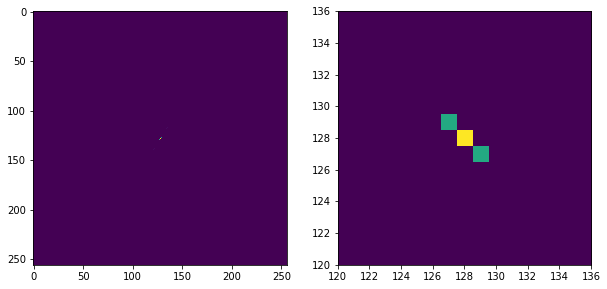

In [21]:
grid = grid_candidates(cands, 'count')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

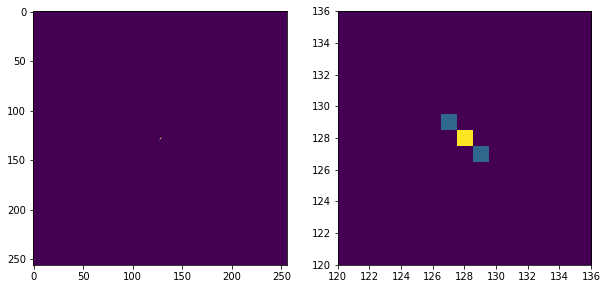

In [22]:
grid = grid_candidates(cands, 'snr')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

In [23]:
mainbuf = p.copy_mainbuf()

(664, 186, 11, 256, 8, 2)


' max/min/mean/rms/sum/S/N = 3.20e+01/0.00e+00/2.31e-01/4.98e-01/1.10e+04/64.3 peak at (0, 0)'

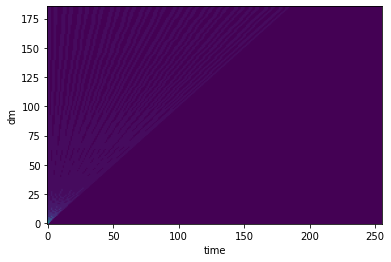

In [24]:
print(mainbuf.shape)
# look at the DM-time plan for UV 0
d = mainbuf[0,:,0,:,0,0]
imshow(d, aspect='auto', origin='lower')
xlabel('time')
ylabel('dm')
printstats(d)

(664, 8, 256)
(5312, 256)


Text(0, 0.5, 'Time')

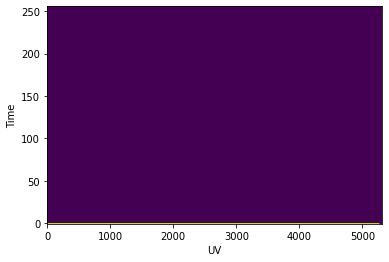

In [25]:
# look at DM=0 for all UVs
d = mainbuf[:,0,0,:,:,0].transpose([0,2,1])
print(d.shape)
d = d.reshape(d.shape[0]*d.shape[1], d.shape[2])
print(d.shape)

imshow(d.T, aspect='auto', origin='lower')
xlabel('UV')
ylabel('Time')

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'baseline_order', 'baseline_shape', 'baselines', 'boxcar_weight', 'ddreader_config', 'ddreader_lut', 'dmax', 'dms', 'dtype', 'fdmt_plan', 'fdmt_scale', 'fft_scale', 'fft_ssr', 'fmax', 'fmin', 'foff', 'freqs', 'get_uv', 'lower_idxs', 'lower_instructions', 'lower_shifts', 'nbl', 'nbox', 'nchunk_time', 'ncin', 'ncu', 'nd', 'ndout', 'nf', 'ngridreg', 'npix', 'nt', 'nuvmax', 'nuvrest', 'nuvrest_max', 'nuvwide', 'save_fdmt_plan_lut', 'save_grid_instructions', 'save_lut', 'save_pad_lut', 'threshold', 'tsamp_s', 'upper_idxs', 'upper_instructions', 'upper_shifts', 'uv_shape', 'uvcells', 'values']


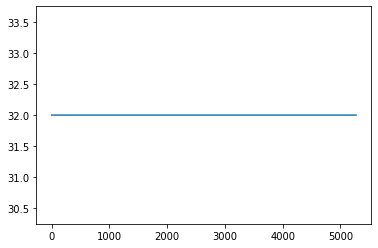

In [26]:
print(dir(plan))
plot(d[:plan.fdmt_plan.nuvtotal, 0])
 # Oh yeah, OK, this makes sense. It's 32 for all baselines because I made every UV = 1. IN practice, it won't be that neat.

# And what if I grid everything properly - i.e. start with baslines,the convert to UV then run the pipeline

In [27]:
print(plan.baseline_shape) # nbl, nc, nt
values.input_scale = 1./16. # need this otherwise somewhere candidates overflow.

(190, 256, 256)


In [28]:
din = np.zeros(plan.baseline_shape, dtype=np.complex64)
din[:, :, 0] = 1 # making this 32 overflows the FDMT


In [29]:
import craft.craco
fast_baseline2uv = craft.craco.FastBaseline2Uv(plan, conjugate_lower_uvs=True)
uv_shape     = (plan.nuvrest, plan.nt, plan.ncin, plan.nuvwide)
uv_out  = np.zeros(uv_shape, dtype=np.complex64)
fast_baseline2uv(din, uv_out)
p.clear_buffers(values)

INFO:craco.search_pipeline:Clearing mainbuf data NBLK=11


In [30]:
print(uv_out.shape)

(659, 256, 32, 8)


In [31]:
p.inbuf.nparr[:,:,:,:,0] = np.round(uv_out[:,:,:,:].real*(values.input_scale*float(1<<NBINARY_POINT_FDMTIN)))
p.inbuf.nparr[:,:,:,:,1] = np.round(uv_out[:,:,:,:].imag*(values.input_scale*float(1<<NBINARY_POINT_FDMTIN)))
print(p.inbuf.nparr.mean())

0.001126232928679818


In [32]:
p.inbuf.copy_to_device()

In [33]:

p.run(0, values).wait()

INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:craco.search_pipeline:Running fdmt
INFO:craco.search_pipeline:fdmt complete
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts


In [34]:
mainbuf = p.copy_mainbuf()

(664, 186, 11, 256, 8, 2)


' max/min/mean/rms/sum/S/N = 6.40e+01/0.00e+00/4.62e-01/9.96e-01/2.20e+04/64.3 peak at (0, 0)'

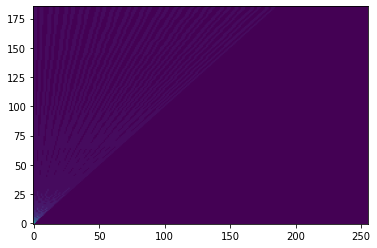

In [35]:
print(mainbuf.shape)
# look at the DM-time plan for UV 0
d = mainbuf[0,:,0,:,0,0]
imshow(d, aspect='auto', origin='lower')
printstats(d)

(664, 8, 256)
(5312, 256)


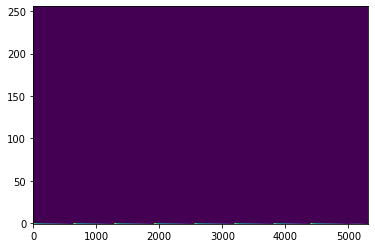

In [36]:
# look at DM=0 for all UVs
d = mainbuf[:,0,0,:,:,0].transpose([0,2,1])
print(d.shape)
d = d.reshape(d.shape[0]*d.shape[1], d.shape[2])
print(d.shape)

imshow(d.T, aspect='auto', origin='lower')

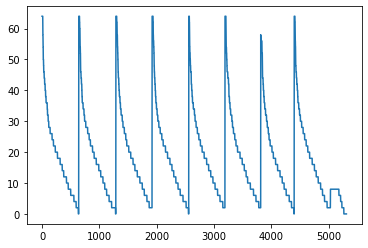

In [37]:
plot(d[:, 0])
# OK so this crazy shape is because of how we're inefficiently packing channels into UV points

In [38]:
cands = p.get_candidates()
print(len(cands))

INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)


41


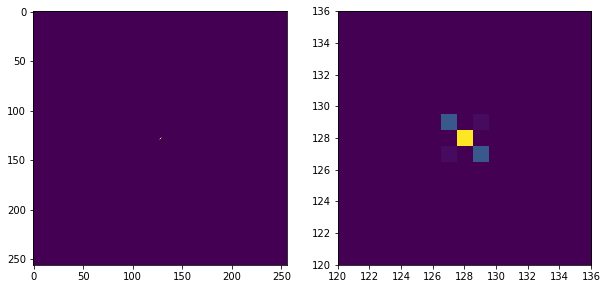

In [39]:
grid = grid_candidates(cands, 'snr')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

In [40]:
print_candidates(cands, 256, 0)

# SNR	upix	vpix	boxc_width	time	dm	iblk	rawsn

47.4	128	128	0		0	0	0	3034
12.5	129	129	0		0	0	0	800
23.3	127	129	0		0	0	0	1493
23.3	129	127	0		0	0	0	1493
12.5	127	127	0		0	0	0	800
33.3	128	128	1		1	1	0	2132
16.4	127	129	1		1	1	0	1049
16.4	129	127	1		1	1	0	1049
25.9	128	128	4		4	2	0	1659
12.9	127	129	1		1	2	0	826
12.9	129	127	1		1	2	0	826
16.3	128	128	7		8	2	0	1043
30.9	128	128	3		4	3	0	1976
14.7	127	129	3		4	3	0	941
14.7	129	127	3		4	3	0	939
23.5	128	128	7		8	3	0	1505
11.0	127	129	7		8	3	0	706
11.0	129	127	7		8	3	0	705
28.8	128	128	4		5	4	0	1844
13.8	127	129	4		5	4	0	882
13.8	129	127	4		5	4	0	882
22.6	128	128	7		8	4	0	1449
10.8	127	129	7		8	4	0	693
10.8	129	127	7		8	4	0	693
23.5	128	128	5		6	5	0	1506
11.5	127	129	5		6	5	0	736
11.5	129	127	5		6	5	0	736
19.9	128	128	7		8	5	0	1274
20.8	128	128	5		6	6	0	1328
10.2	127	129	5		6	6	0	655
10.2	129	127	5		6	6	0	656
18.3	128	128	7		8	6	0	1173
19.1	128	128	6		7	7	0	1221
17.5	128	128	7		8	7	0	1119
14.5	128	128	6		7	8	0	931
15.3	128	128	7		8	8	0	982

# How about pulse with Nonzero DM?

In [41]:
from craft import simfrb

In [42]:
dm = 100
toff = 10
tsamp = 1.7
frb = simfrb.mkfrb_fdmt(plan.fmin/1e9, plan.foff/1e9, plan.nf, tsamp, dm, toffset=toff, ntimes=plan.nt)

(50.0, 100.0)

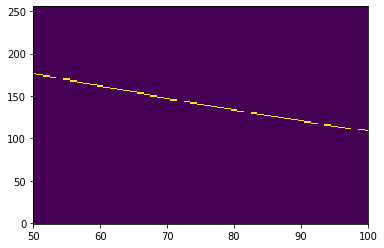

In [43]:
imshow(frb.T, aspect='auto', origin='lower', interpolation='none')
xlim(50,100)

In [44]:
din[:] = 0
print(din.shape, frb.shape)
din[:] = frb.T
fast_baseline2uv(din, uv_out)
assert din.sum() == uv_out.sum(), 'baseline2uv didnt conserve energy'

(190, 256, 256) (256, 256)


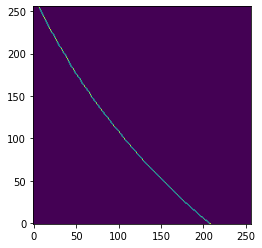

In [45]:
imshow(din[0,:,:].real, origin='lower')

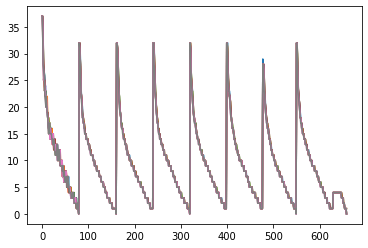

In [46]:
plot(uv_out.sum(axis=1).sum(axis=1).real)

(659, 256, 32, 8) (49590+0j) (49590+0j)


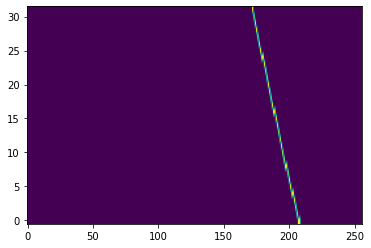

In [47]:
print(uv_out.shape, uv_out.sum(), din.sum())
imshow(uv_out[1,:,:,0].real.T, aspect='auto', origin='lower')

In [48]:
# This one seems to hang when together with the 3 cells below. Let's space it out.
p.clear_buffers(values)


INFO:craco.search_pipeline:Clearing mainbuf data NBLK=11


In [49]:

p.inbuf.nparr[:,:,:,:,0] = np.round(uv_out[:,:,:,:].real*(values.input_scale*float(1<<NBINARY_POINT_FDMTIN)))
p.inbuf.nparr[:,:,:,:,1] = np.round(uv_out[:,:,:,:].imag*(values.input_scale*float(1<<NBINARY_POINT_FDMTIN)))
p.inbuf.copy_to_device()
values.run_fdmt = True
values.run_image = True
values.threshold = 10


In [50]:
p.run(0, values).wait()

INFO:craco.search_pipeline:nConfiguration just before pipeline running 
ndm=512 nchunk_time=32 tblk=0 nuv=5272 nparallel_uv=2636 nurest=659 load_luts=1 nplane=16384 threshold=640 shift1=0 shift2=7 fft_cfg=400001c0

INFO:craco.search_pipeline:Running fdmt
INFO:craco.search_pipeline:fdmt complete
INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)
INFO:craco.search_pipeline:Candidates cleared
INFO:craco.search_pipeline:10 kernels running
INFO:craco.search_pipeline:Waiting for 10 starts


In [51]:
cands = p.get_candidates()
print_candidates(cands, 256, 0)

INFO:craco.search_pipeline:Last candidate is (0, 0, 0, 0, 0)


# SNR	upix	vpix	boxc_width	time	dm	iblk	rawsn

10.0	128	128	7		200	186	0	642
10.0	128	128	7		201	187	0	643
10.7	128	128	3		198	188	0	686
10.8	128	128	6		201	188	0	694
10.8	128	128	3		199	189	0	689
11.7	128	128	7		203	189	0	749
10.9	128	128	1		198	190	0	698
12.7	128	128	6		203	190	0	814
11.0	128	128	1		199	191	0	702
12.8	128	128	6		204	191	0	819
10.3	128	128	7		208	191	0	662
14.2	128	128	7		206	192	0	909
11.3	128	128	6		208	192	0	722
14.6	128	128	7		207	193	0	936
13.6	128	128	7		208	193	0	872
16.4	128	128	7		207	194	0	1050
15.2	128	128	7		208	194	0	971
17.9	128	128	6		207	195	0	1146
17.0	128	128	7		208	195	0	1089
17.3	128	128	5		207	196	0	1110
18.5	128	128	6		208	196	0	1181
16.3	128	128	4		207	197	0	1042
20.1	128	128	5		208	197	0	1284
18.4	128	128	3		207	198	0	1177
21.6	128	128	4		208	198	0	1382
10.7	127	129	4		208	198	0	685
10.7	129	127	4		208	198	0	685
21.4	128	128	1		207	199	0	1368
10.3	127	129	1		207	199	0	662
10.3	129	127	1		207	199	0	662
24.5	128	128	3		208	199	0	1569
12.3	127	129

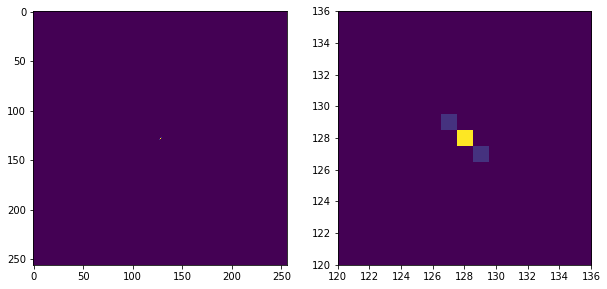

In [52]:
grid = grid_candidates(cands, 'snr')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

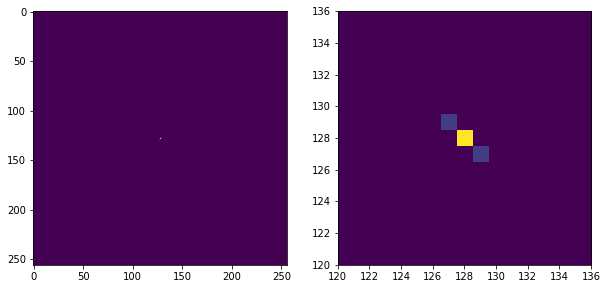

In [53]:
grid = grid_candidates(cands, 'count')
fig, ax = subplots(1,2)
ax[0].imshow(grid)
ax[1].imshow(grid)
ax[1].set_xlim(128-8,128+8)
ax[1].set_ylim(128-8,128+8)
fig.set_size_inches([10,5])

In [54]:
mainbuf = p.copy_mainbuf()

(664, 186, 11, 256, 8, 2)


' max/min/mean/rms/sum/S/N = 7.40e+01/0.00e+00/3.78e-01/1.39e+00/1.80e+04/53.1 peak at (36, 208)'

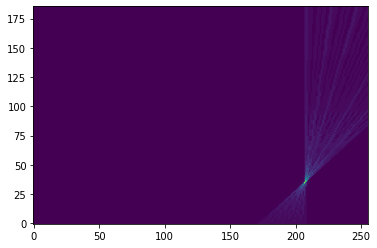

In [55]:
print(mainbuf.shape)
d = mainbuf[0,:,0,:,0,0]
imshow(d, aspect='auto', origin='lower')
printstats(d)